# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG 
!mkdir FIG/FRAME
!mkdir WEIGHTS 
!mkdir DATA

mkdir: cannot create directory ‘FIG’: File exists
mkdir: cannot create directory ‘WEIGHTS’: File exists


## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X_original.shape)

(70000, 784)


## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=True
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('0', '1', '2')
dataset with 21770 points, each with 784 bits

first 10 MNIST data points


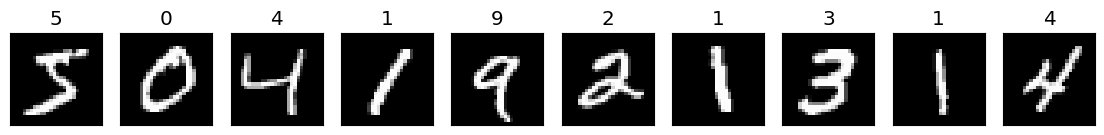

first 10 MNIST-3 data points


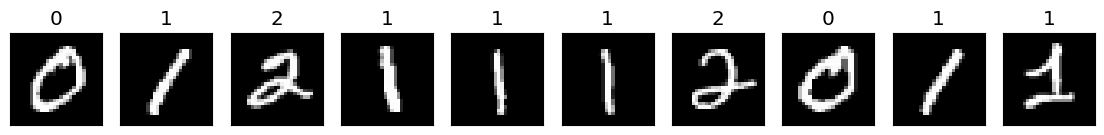

first 10 MNIST-3 data points, binarized


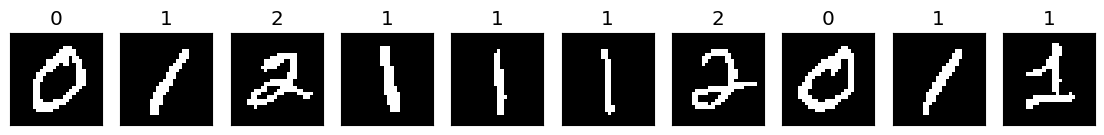

each of Nd=21770 data has D=784 bits


In [4]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

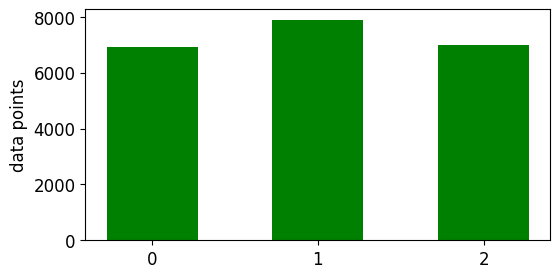

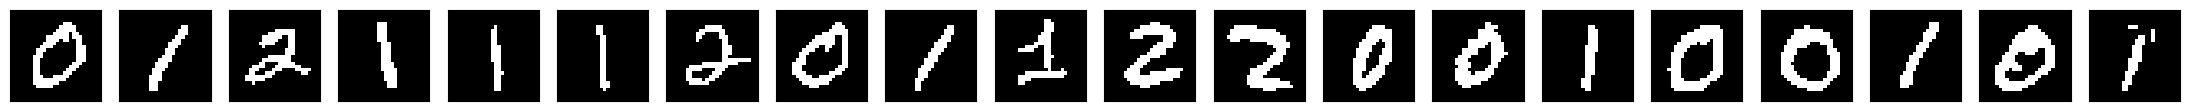

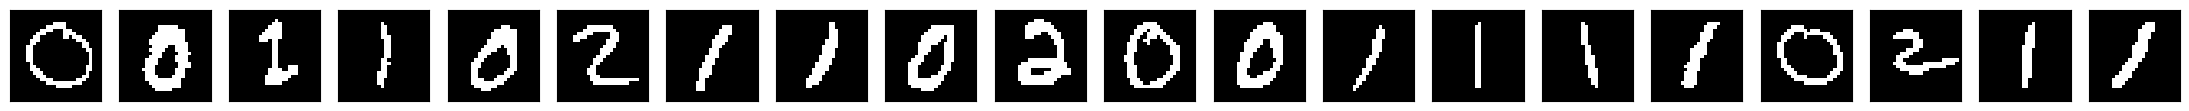

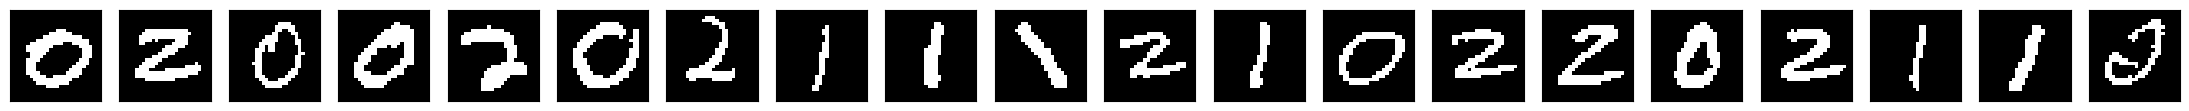

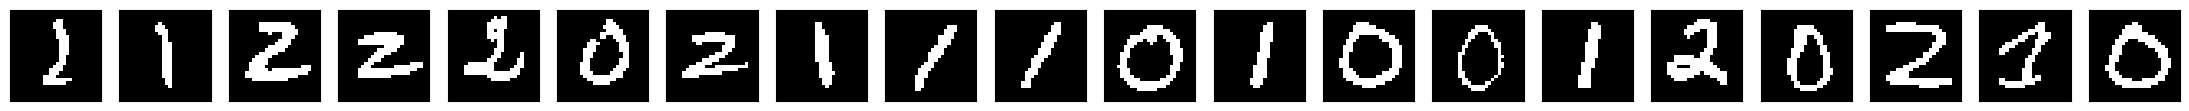

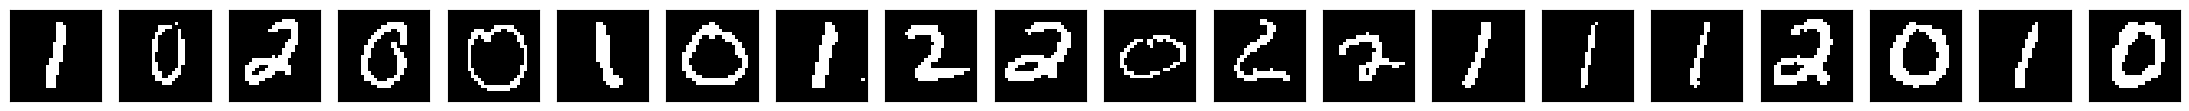

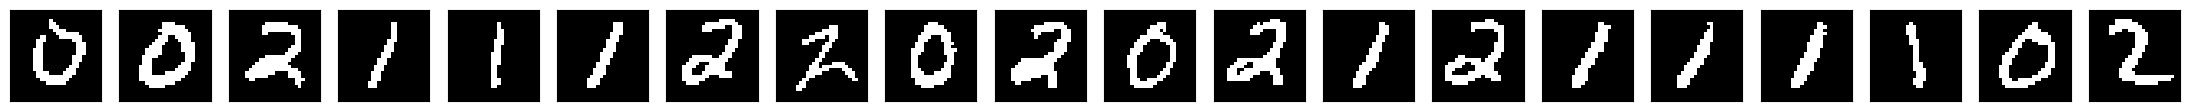

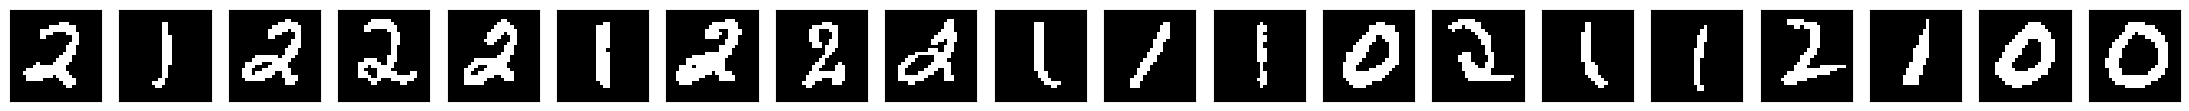

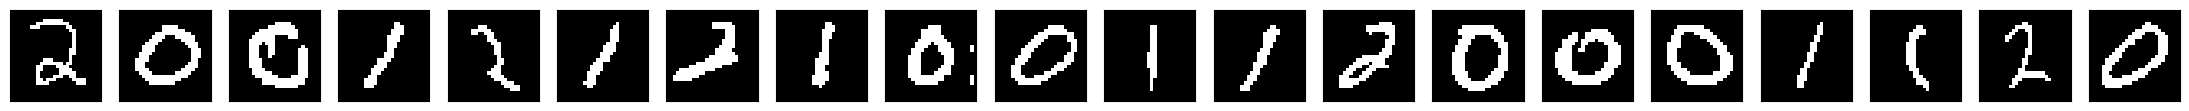

In [5]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [7]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [8]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [9]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


In [10]:
class LOGlike(object):
    """
    FORMAT:
    D = 784      # visible
    L = 12       # hidden
    M = len(x)   # number of data points
    a = np.random.uniform(-1, 1, D)
    b = np.random.uniform(-1, 1, L)
    x = np.random.randint(0, 2, (M, D))
    z = np.random.randint(0, 2, L)
    w = np.random.uniform(-1, 1, (D, L))
    """

    def __init__(self, x, L):
        self.a = None # a   # visible
        self.b = None # b   # hidden
        self.D = None # a.shape[0]
        self.L = None # b.shape[0]
        self.x = x
        self.M = len(x)
        self.w = None # w
        self.q = None
        self.esit = [L]
        self.z = None
        #
    #####
    #
    def inizialization(self, a, b, w):
        self.a = a   # visible
        self.b = b   # hidden
        self.D = a.shape[0]
        self.L = b.shape[0]
        self.w = w
        self.make_z_states()
        self.H_and_G()

    def H_and_G(self):
        
        self.H_z_matrix = np.array([self.H(z) for z in self.z])  # Shape (2^L, D)
        self.G_z_vector = np.array([self.G(z) for z in self.z])  # Shape (2^L,)

        
    def make_z_states(self):
        """
        2^L config
        """
        
        def get_bin(i, L):
            b = bin(i)[2:]
            return ("0" * (L - len(b))) + b
            #
        #####
        #
        self.z = np.array([[int(bit) for bit in get_bin(i, self.L)]
                                       for i in range(2 ** self.L)])
        if SPINS == True: self.z[self.z == 0] = -1
        #
    #####
    #
    def H(self, z):
        """
        H(z) = a + w @ z
        """
        
        return self.a + np.dot(self.w, z)
        #
    #####
    #
    def G(self, z):
        """
        G(z) = exp(b @ z).
        """
        
        return np.exp(np.dot(self.b, z))
        #
    #####
    #

    def get_numerator(self, x):
        """
        ln{sum_z[G(z) * exp[dot(H_i(z) * x_i)]]}
        """
        
        exp_H_x   = np.exp(self.H_z_matrix @ x)  # Shape (2^L,)
        numerator = np.sum(self.G_z_vector * exp_H_x)
        return np.log(numerator)

    def get_denominator(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[(1 + H_i(z)) / q]]}
        """

        # q average over 1+exp(H_i(z))
        self.q = 1 + np.exp(np.mean(self.H_z_matrix))

        # sum_Z
        prod_H_q = np.prod((1 + np.exp(self.H_z_matrix)) / self.q, axis=1)  # Shape (2^L,)
        Z_value  = np.sum(self.G_z_vector * prod_H_q)

        return self.D * np.log(self.q) + np.log(Z_value)

    def get_denominator_spin(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[cosh(H_i(z)) / q]]}
        """

        # q average over cosh(H_i(z))
        self.q = np.cosh(np.mean(self.H_z_matrix))

        # sum_Z
        prod_H_q = np.prod(np.cosh(self.H_z_matrix) / self.q, axis=1)  # Shape (2^L,)
        Z_value  = np.sum(self.G_z_vector * prod_H_q)

        return self.D * np.log(self.q) + np.log(Z_value)    
    
    def run(self):
        """
        l_θ(x) = ln{sum_z[G(z) * exp(H_i(z) * x_i)]} - ln{Z}
        """
        if (SPINS == False):
            lnZ = self.get_denominator()
            log_likelihoods = np.array([self.get_numerator(x) - lnZ for x in self.x])
            self.esit.append(np.mean(log_likelihoods))
        else:
            lnZ = self.get_denominator_spin()
            log_likelihoods = np.array([self.get_numerator(x) - lnZ for x in self.x])
            self.esit.append(np.mean(log_likelihoods)) 

    def save(self):
        file = open("L/" + str(self.L) + ".txt", "tw")
        file.write(str(self.esit))
        file.close()
        #
    #####
    #
#####
#
#Exe
log_likehood = LOGlike(data, L)
#log_likehood.run()
#print("Log-likelihood media sul dataset:", log_likehood.print())

# RBM train


Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

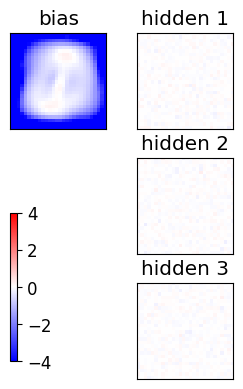

Starting the training
[12775  9990  2591 14746 12913    95 10946  3140  2405 11413]
[18422  9442  1294  3194 11001 20412  2137  6279  9421  4536]
[12654  9403  4522  7811 18357  3584 15910 14437 12006 15318]
[11426  9755 10468  7820  2941   937 18123 11759 15079 20283]
epoch 1 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 2 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 3 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 4 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 5 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 6 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 7 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 8 / 150  Nt: 2  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 9 / 150  Nt: 2  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= T

<Figure size 640x480 with 0 Axes>

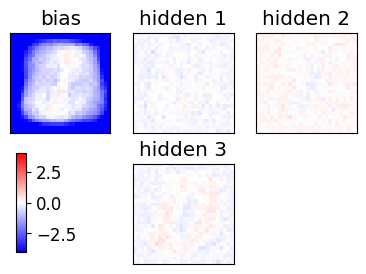

/tmp/ipykernel_26296/1984186409.py:84: RuntimeWarning: overflow encountered in exp
  exp_H_x   = np.exp(self.H_z_matrix @ x)  # Shape (2^L,)


epoch 11 / 150  Nt: 2  N: 12  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 12 / 150  Nt: 2  N: 12  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 13 / 150  Nt: 2  N: 13  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 14 / 150  Nt: 2  N: 13  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 15 / 150  Nt: 2  N: 14  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 16 / 150  Nt: 2  N: 14  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 17 / 150  Nt: 2  N: 15  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 18 / 150  Nt: 2  N: 16  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 19 / 150  Nt: 2  N: 17  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 20 / 150  Nt: 2  N: 17  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

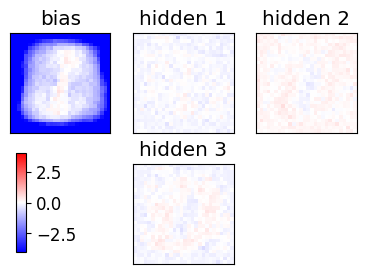

epoch 21 / 150  Nt: 2  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 22 / 150  Nt: 2  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 23 / 150  Nt: 2  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 24 / 150  Nt: 2  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 25 / 150  Nt: 2  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 26 / 150  Nt: 2  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 27 / 150  Nt: 2  N: 24  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 28 / 150  Nt: 2  N: 26  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 29 / 150  Nt: 2  N: 27  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 30 / 150  Nt: 2  N: 28  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

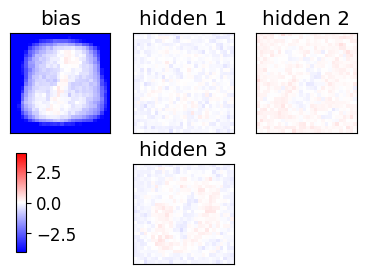

epoch 31 / 150  Nt: 2  N: 29  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 32 / 150  Nt: 2  N: 31  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 33 / 150  Nt: 2  N: 32  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 34 / 150  Nt: 2  N: 34  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 35 / 150  Nt: 2  N: 35  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 36 / 150  Nt: 2  N: 37  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 37 / 150  Nt: 2  N: 38  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 38 / 150  Nt: 2  N: 40  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 39 / 150  Nt: 2  N: 41  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 40 / 150  Nt: 2  N: 43  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

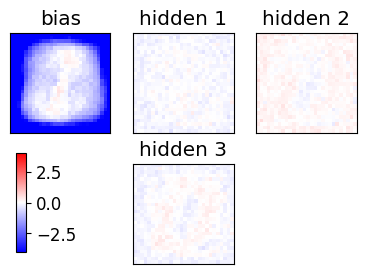

epoch 41 / 150  Nt: 2  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 42 / 150  Nt: 2  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 43 / 150  Nt: 2  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 44 / 150  Nt: 2  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 45 / 150  Nt: 2  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 46 / 150  Nt: 2  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 47 / 150  Nt: 2  N: 56  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 48 / 150  Nt: 2  N: 58  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 49 / 150  Nt: 2  N: 60  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 50 / 150  Nt: 2  N: 62  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

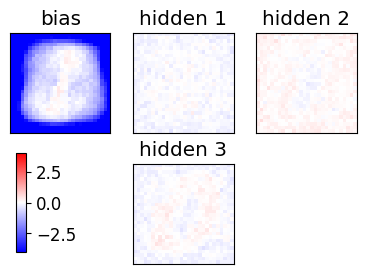

epoch 51 / 150  Nt: 2  N: 65  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 52 / 150  Nt: 2  N: 67  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 53 / 150  Nt: 2  N: 69  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 54 / 150  Nt: 2  N: 71  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 55 / 150  Nt: 2  N: 74  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 56 / 150  Nt: 2  N: 76  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 57 / 150  Nt: 2  N: 79  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 58 / 150  Nt: 2  N: 81  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 59 / 150  Nt: 2  N: 84  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 60 / 150  Nt: 2  N: 86  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

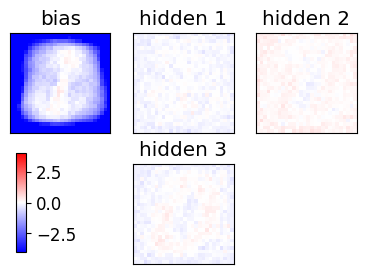

epoch 61 / 150  Nt: 2  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 62 / 150  Nt: 2  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 63 / 150  Nt: 2  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 64 / 150  Nt: 2  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 65 / 150  Nt: 2  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 66 / 150  Nt: 2  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 67 / 150  Nt: 2  N: 106  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 68 / 150  Nt: 2  N: 109  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 69 / 150  Nt: 2  N: 112  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 70 / 150  Nt: 2  N: 115  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

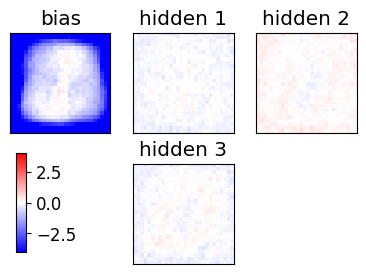

epoch 71 / 150  Nt: 2  N: 118  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 72 / 150  Nt: 2  N: 121  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 73 / 150  Nt: 2  N: 124  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 74 / 150  Nt: 2  N: 127  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 75 / 150  Nt: 2  N: 130  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 76 / 150  Nt: 2  N: 134  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 77 / 150  Nt: 2  N: 137  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 78 / 150  Nt: 2  N: 140  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 79 / 150  Nt: 2  N: 144  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 80 / 150  Nt: 2  N: 147  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

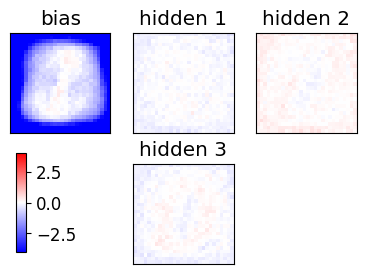

epoch 81 / 150  Nt: 2  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 82 / 150  Nt: 2  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 83 / 150  Nt: 2  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 84 / 150  Nt: 2  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 85 / 150  Nt: 2  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 86 / 150  Nt: 2  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 87 / 150  Nt: 2  N: 173  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 88 / 150  Nt: 2  N: 177  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 89 / 150  Nt: 2  N: 180  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 90 / 150  Nt: 2  N: 184  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

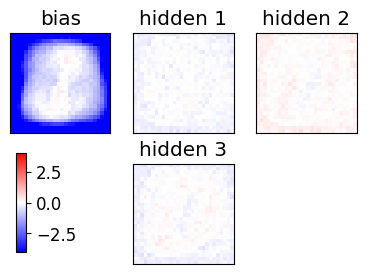

epoch 91 / 150  Nt: 2  N: 188  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 92 / 150  Nt: 2  N: 192  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 93 / 150  Nt: 2  N: 196  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 94 / 150  Nt: 2  N: 200  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 95 / 150  Nt: 2  N: 205  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 96 / 150  Nt: 2  N: 209  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 97 / 150  Nt: 2  N: 213  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 98 / 150  Nt: 2  N: 217  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 99 / 150  Nt: 2  N: 221  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 100 / 150  Nt: 2  N: 226  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

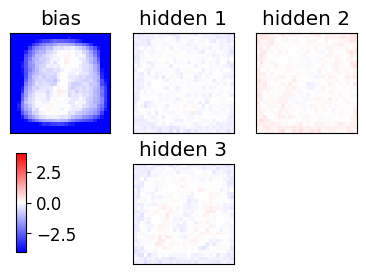

epoch 101 / 150  Nt: 2  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 102 / 150  Nt: 2  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 103 / 150  Nt: 2  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 104 / 150  Nt: 2  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 105 / 150  Nt: 2  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 106 / 150  Nt: 2  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 107 / 150  Nt: 2  N: 257  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 108 / 150  Nt: 2  N: 262  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 109 / 150  Nt: 2  N: 267  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 110 / 150  Nt: 2  N: 272  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

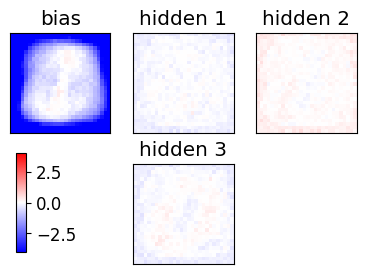

epoch 111 / 150  Nt: 2  N: 277  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 112 / 150  Nt: 2  N: 281  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 113 / 150  Nt: 2  N: 286  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 114 / 150  Nt: 2  N: 291  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 115 / 150  Nt: 2  N: 296  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 116 / 150  Nt: 2  N: 301  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 117 / 150  Nt: 2  N: 306  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 118 / 150  Nt: 2  N: 312  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 119 / 150  Nt: 2  N: 317  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 120 / 150  Nt: 2  N: 322  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

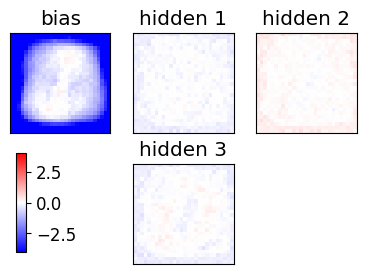

epoch 121 / 150  Nt: 2  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 122 / 150  Nt: 2  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 123 / 150  Nt: 2  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 124 / 150  Nt: 2  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 125 / 150  Nt: 2  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 126 / 150  Nt: 2  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 127 / 150  Nt: 2  N: 360  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 128 / 150  Nt: 2  N: 365  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 129 / 150  Nt: 2  N: 371  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 130 / 150  Nt: 2  N: 377  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

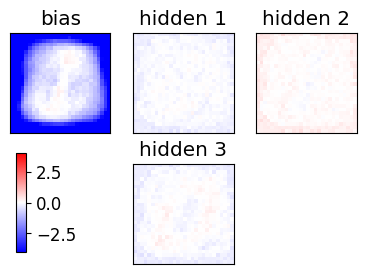

epoch 131 / 150  Nt: 2  N: 383  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 132 / 150  Nt: 2  N: 388  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 133 / 150  Nt: 2  N: 394  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 134 / 150  Nt: 2  N: 400  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 135 / 150  Nt: 2  N: 406  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 136 / 150  Nt: 2  N: 412  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 137 / 150  Nt: 2  N: 418  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 138 / 150  Nt: 2  N: 424  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 139 / 150  Nt: 2  N: 430  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 140 / 150  Nt: 2  N: 436  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

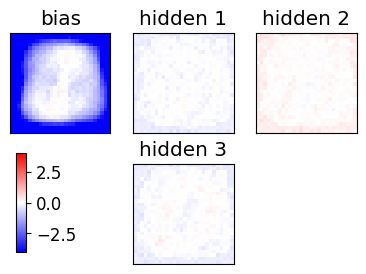

epoch 141 / 150  Nt: 2  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 142 / 150  Nt: 2  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 143 / 150  Nt: 2  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 144 / 150  Nt: 2  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 145 / 150  Nt: 2  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 146 / 150  Nt: 2  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 147 / 150  Nt: 2  N: 480  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 148 / 150  Nt: 2  N: 486  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 149 / 150  Nt: 2  N: 493  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False
epoch 150 / 150  Nt: 2  N: 500  L: 3  rate: 0.05  gam: 0.001 SPINS= True POTTS= False


<Figure size 640x480 with 0 Axes>

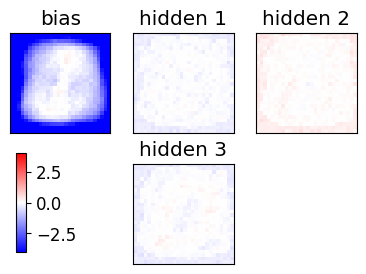

END of learning phase


In [11]:
# random seed for reproducibility
np.random.seed(12345)

# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(D,L)
#a = sigma * np.random.randn(D)
# using Hinton initialization of visible biases
a = Hinton_bias_init(data)
# hidden biases initialized to zero
b = np.zeros(L)
#print("w=",w);print("a=",a);print("b=",b)

# nr of epochs
Nepoch=150
# minibatches per epoch
Nmini=20
# minibatch size at initial epoch and final one
N_ini,N_fin=10,500
print(f"Nepoch={Nepoch}\nNmini={Nmini}")
# number of CD steps
Nt=2

# recording history of weights ("E" means epoch)
wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
miniE = np.zeros(Nepoch+1)
pzE=np.zeros((Nepoch+1,Nz))
if GRAD=="RMSprop": 
    gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)

indices=np.arange(Nd).astype("int")
plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)

# for the plot with panels
Ncols=min(8,max(2,L//2))

if POTTS: print("Starting the training, POTTS=True")
else: print("Starting the training")

# Note: here an epoch does not analyze the whole dataset
for epoch in range(1,1+Nepoch):
    # q maps epochs to interval [0,1]
    q = (epoch-1.)/(Nepoch-1.) 
    # N, size of the mini batch
    # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
    N = int(N_ini + (N_fin-N_ini)*(q**2))
    #  l_rate interpolates between initial and final value
    l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

    for mini in range(Nmini):
        # initializitation for averages in minibatch
        # visible variables "v" --> "x"
        #  hidden variables "h" --> "z"
        x_data, x_model = np.zeros(D),np.zeros(D)
        z_data, z_model = np.zeros(L),np.zeros(L)
        xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
        pz = np.zeros(L)
        
        # Minibatch of size N: points randomply picked (without repetition) from data
        selected = np.random.choice(indices,N,replace=False)
        if epoch==1 and mini<=3: print(selected)
        
        for k in range(N):
            ###################################
            x0 = data[selected[k]]
            # positive CD phase: generating z from x[k]
            z = CD_step(x0,w,b,POTTS=POTTS)
            x_data  += x0
            z_data  += z
            xz_data += np.outer(x0,z)
            # fantasy
            zf=np.copy(z)
            # Contrastive divergence with Nt steps
            for t in range(Nt):
                # negative CD pzase: generating fantasy xf from fantasy zf
                xf = CD_step(zf,w.T,a)
                # positive CD phase: generating fantasy zf from fantasy xf 
                zf = CD_step(xf,w,b,POTTS=POTTS)
            x_model += xf
            z_model += zf
            xz_model+= np.outer(xf,zf)
            # recording probability of encoding in z-space, if POTTS
            if POTTS: pz[zf]+=1
            ###################################
        
        # gradient of the likelihood: follow it along its positive direction
        gw_d,gw_m = xz_data/N, xz_model/N
        ga_d,ga_m = x_data/N, x_model/N
        gb_d,gb_m = z_data/N, z_model/N
        gw=np.copy(gw_d - gw_m)
        ga=np.copy(ga_d - ga_m)
        gb=np.copy(gb_d - gb_m)

        # gradient ascent step
        if GRAD=="RMSprop":
            # RMSprop gradient ascent
            gw2 = beta*gw2+(1-beta)*np.square(gw)
            ga2 = beta*ga2+(1-beta)*np.square(ga)
            gb2 = beta*gb2+(1-beta)*np.square(gb)
            w += l_rate*gw/sqrt(epsilon+gw2)
            a += l_rate*ga/sqrt(epsilon+ga2)
            b += l_rate*gb/sqrt(epsilon+gb2)
        else: 
            # defaulting to the vanilla stochastic gradient ascent (SGD)
            w += l_rate*gw
            a += l_rate*ga
            b += l_rate*gb
        # regularization (LASSO)
        if gamma>0.:
            w -= (gamma*l_rate)*sign(w)
            a -= (gamma*l_rate)*sign(a)
            b -= (gamma*l_rate)*sign(b)

    wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
    aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
    bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
    miniE[epoch]=N
    if POTTS: pzE[epoch] = pz/np.sum(pz)
    print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
          " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)

    if Nepoch<=100 or epoch%10==0 or epoch==Nepoch:
        plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
        log_likehood.inizialization(a, b, w)
        log_likehood.run()
            
    str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")

print("END of learning phase")
log_likehood.save()

## Test generative power of the trained RBM

<Figure size 640x480 with 0 Axes>

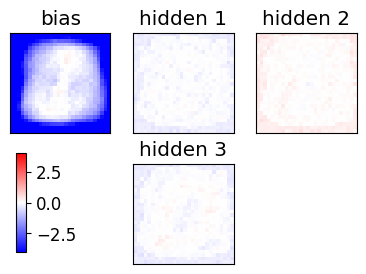

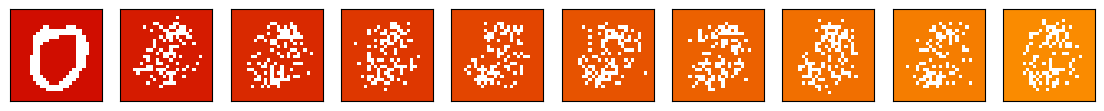

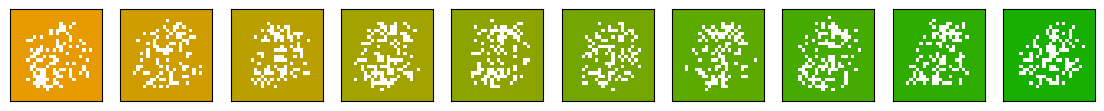

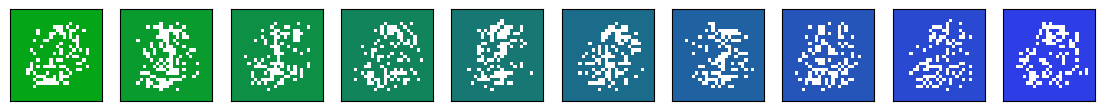

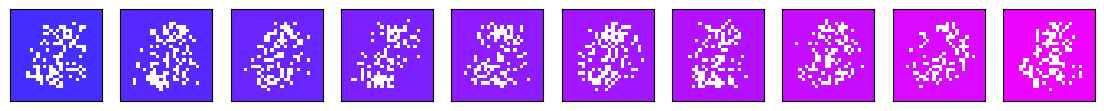

L: 3     amplification of weights: 1.0


In [12]:
ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

NE= 150


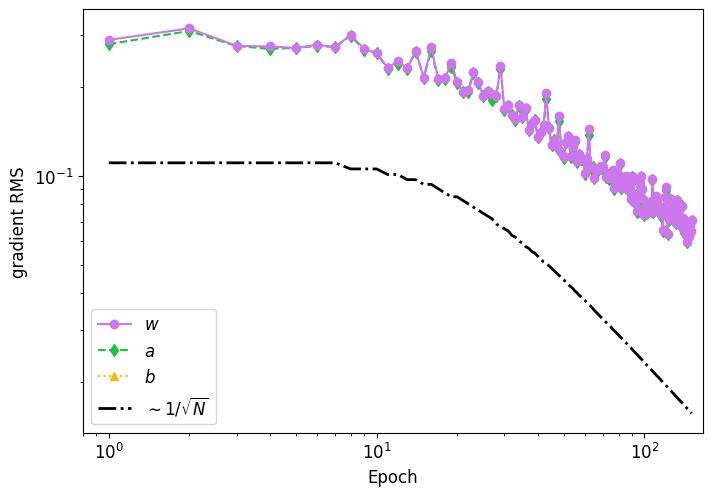

FIG/RBM_grad_MNIST3_E150_N10-500_RMSprop-0.05-0.05_CD-2_L3_reg0.001.png


In [13]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [14]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

WEIGHTS/w_RBM_MNIST3_L3_RMSprop-0.05-0.05_Ep150_reg0.001_SPINS_20250317_1637.npy
WEIGHTS/b_RBM_MNIST3_L3_RMSprop-0.05-0.05_Ep150_reg0.001_SPINS_20250317_1637.npy
WEIGHTS/a_RBM_MNIST3_L3_RMSprop-0.05-0.05_Ep150_reg0.001_SPINS_20250317_1637.npy


In [15]:
Nd

21770

In [12]:
L3  = eval(open("L/3.txt").read())[1:]
L4  = eval(open("L/4.txt").read())[1:]
L5  = eval(open("L/5.txt").read())[1:]
L6  = eval(open("L/6.txt").read())[1:]
L7  = eval(open("L/7.txt").read())[1:]
L8  = eval(open("L/8.txt").read())[1:]
L9  = eval(open("L/9.txt").read())[1:]
L10 = eval(open("L/10.txt").read())[1:]
L11 = eval(open("L/11.txt").read())[1:]
L12 = eval(open("L/12.txt").read())[1:]
L13 = eval(open("L/13.txt").read())[1:]

NameError: name 'inf' is not defined

In [5]:
import matplotlib.pyplot as plt

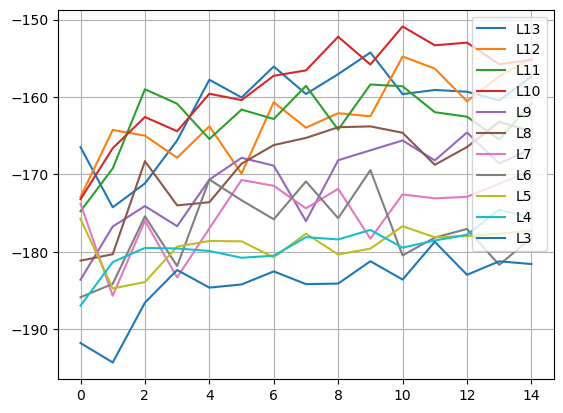

In [97]:
plt.plot(L13, label = "L13")
plt.plot(L12, label = "L12")
plt.plot(L11, label = "L11")
plt.plot(L10, label = "L10")
plt.plot(L9,  label = "L9")
plt.plot(L8,  label = "L8")
plt.plot(L7,  label = "L7")
plt.plot(L6,  label = "L6")
plt.plot(L5,  label = "L5")
plt.plot(L4,  label = "L4")
plt.plot(L3,  label = "L3")
plt.legend(loc = "upper right")
plt.grid()
plt.show()

In [81]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs) -> 'Legend'
    Place a legend on the Axes.

    Call signatures::

        legend()
        legend(handles, labels)
        legend(handles=handles)
        legend(labels)

    The call signatures correspond to the following different ways to use
    this method:

    **1. Automatic detection of elements to be shown in the legend**

    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.

    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::

        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()

    or::

        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()

    .. note::
        Specific artists can be excluded from the automatic legend element
        selectio

In [7]:
scipy.special.logsumexp

<function scipy.special._logsumexp.logsumexp(a, axis=None, b=None, keepdims=False, return_sign=False)>